# Analyze the distribution of GitHub creation dates compared to HN submission dates

## setup

In [1]:
# Hackernews GitHub Project Timeline Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from datetime import datetime
import time
from dateutil.parser import parse
from tqdm.notebook import tqdm
import re
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from urllib.parse import urlparse
import os

# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")


In [2]:
# 1. Load the Hackernews data
def load_hn_data(filepath):
    """Load Hackernews story data from CSV."""
    df = pd.read_csv(filepath)

    # Convert Unix timestamp to datetime
    df['submission_date'] = pd.to_datetime(df['time'], unit='s')

    # Extract GitHub username and repo name from URL
    def extract_github_info(url):
        try:
            if not isinstance(url, str) or 'github.com' not in url:
                return None, None

            parsed = urlparse(url)
            if parsed.netloc != 'github.com':
                return None, None

            path_parts = [p for p in parsed.path.split('/') if p]
            if len(path_parts) >= 2:
                return path_parts[0], path_parts[1]
            return None, None
        except:
            return None, None

    # Apply extraction to create new columns
    df[['github_username', 'github_repo']] = df.apply(
        lambda row: pd.Series(extract_github_info(row['url'])), axis=1
    )

    # Filter only GitHub repositories
    github_df = df[df['github_username'].notna() & df['github_repo'].notna()].copy()

    # Create full repo name column (username/repo)
    github_df['full_repo_name'] = github_df['github_username'] + '/' + github_df['github_repo']

    return github_df


In [ ]:
# 3. Merge HN data with GitHub metadata
def merge_datasets(hn_df, github_df):
    """Merge Hackernews data with GitHub repo metadata."""

    # Merge on the full repo name
    merged_df = hn_df.merge(github_df, on='full_repo_name', how='left')

    # Ensure both datetime fields have the same timezone handling
    # They should both be UTC by now, but this is a safeguard
    if 'submission_date' in merged_df.columns and 'repo_creation_date' in merged_df.columns:
        # Make sure both are timezone aware with UTC
        if merged_df['submission_date'].dt.tz is None:
            merged_df['submission_date'] = merged_df['submission_date'].dt.tz_localize('UTC')
        if merged_df['repo_creation_date'].dt.tz is None:
            merged_df['repo_creation_date'] = merged_df['repo_creation_date'].dt.tz_localize('UTC')

    # Calculate time difference between repo creation and HN submission
    merged_df['days_difference'] = (merged_df['submission_date'] - merged_df['repo_creation_date']).dt.total_seconds() / (60 * 60 * 24)

    # Flag for submission timing relative to repo creation
    merged_df['submitted_before_creation'] = merged_df['days_difference'] < 0

    # Create time buckets
    conditions = [
        (merged_df['days_difference'] < 0),
        (merged_df['days_difference'] == 0),
        (merged_df['days_difference'] > 0) & (merged_df['days_difference'] <= 7),
        (merged_df['days_difference'] > 7) & (merged_df['days_difference'] <= 30),
        (merged_df['days_difference'] > 30) & (merged_df['days_difference'] <= 90),
        (merged_df['days_difference'] > 90) & (merged_df['days_difference'] <= 365),
        (merged_df['days_difference'] > 365)
    ]

    choices = [
        'Before Creation',
        'Same Day',
        'First Week',
        'First Month',
        '1-3 Months',
        '3-12 Months',
        'Over a Year'
    ]

    merged_df['time_bucket'] = np.select(conditions, choices, default='Unknown')

    return merged_df

In [34]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': True,
          'axes.edgecolor': '.8',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': True,
          'axes.grid.axis': 'both',


In [41]:
plt.rcParams.update({'font.size': 25, 'xtick.labelsize': 25, 'ytick.labelsize': 20, })
fontsize = 25

# 4. Visualizations
def create_visualizations(merged_df):
    """Create various visualizations to analyze the data."""
    # Filter out rows with missing creation dates
    df = merged_df.dropna(subset=['repo_creation_date']).copy()

    if len(df) == 0:
        print("No valid data available for visualization after filtering.")
        return

    # 1. Histogram of time differences
    plt.figure(figsize=(14, 8))

    # Focus on a reasonable range (-30 to 365 days)
    filtered_df = df[(df['days_difference'] >= -300) & (df['days_difference'] <= 965)]

    sns.histplot(filtered_df['days_difference'], bins=20, kde=True)
    # plt.title('Time Difference Between GitHub Repo Creation and HN Submission', fontsize=fontsize)
    plt.xticks(rotation=45,  fontsize=fontsize)
    plt.xlabel('#Days', fontsize=fontsize)
    plt.ylabel('Frequency', fontsize=fontsize)
    plt.axvline(x=0, color='red', linestyle='--', label='GH Repository Creation Date')
    plt.legend(fontsize=fontsize)
    plt.tight_layout()
    plt.savefig('histogram_time_difference.pdf')
    plt.show()

    # 2. Scatter plot timeline
    plt.figure(figsize=(14, 8))

    # Filter extreme outliers for better visualization
    scatter_df = df[(df['days_difference'] >= -300) & (df['days_difference'] <= 965)]

    plt.scatter(scatter_df['repo_creation_date'], scatter_df['days_difference'], alpha=0.7)
    # plt.title('Time to HN Submission vs. GitHub Repo Creation Date', fontsize=fontsize)
    plt.xticks(rotation=45, fontsize=fontsize)
    plt.xlabel('GitHub Repository Creation Date', fontsize=fontsize)
    plt.ylabel('Days Until HN Submission', fontsize=fontsize)
    plt.axhline(y=0, color='red', linestyle='--', label='Same Day')
    plt.legend(fontsize=fontsize)

    # Format x-axis to show years
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())

    plt.tight_layout()
    plt.savefig('scatter_timeline.pdf')
    plt.show()
    return

## running

loading

In [ ]:
# 1. Load HN data
print("Loading Hackernews data...")
HN_STORIES_GH_CSV = '../dataset/hn-stories-gh-ai.csv'
hn_data = load_hn_data(HN_STORIES_GH_CSV)
print(f"Found {len(hn_data)} GitHub repositories in HN submissions")
hn_data.head()

Loading Hackernews data...
Found 2195 GitHub repositories in HN submissions


,by,dead,id,score,text,time,timestamp,title,type,url,submission_date,github_username,github_repo,full_repo_name
0,dhuynh95,NaN,31355348,32,NaN,1652368380,2022-05-12 15:13:00 UTC,"BlindAI: Open-source, fast and privacy-friendl...",story,https://github.com/mithril-security/blindai,2022-05-12 15:13:00,mithril-security,blindai,mithril-security/blindai
1,ArdelleF,NaN,31405976,36,NaN,1652761021,2022-05-17 04:17:01 UTC,OpenAI Codex Python to C++ Code Generator,story,https://github.com/alxschwrz/codex_py2cpp,2022-05-17 04:17:01,alxschwrz,codex_py2cpp,alxschwrz/codex_py2cpp
2,jonbaer,NaN,34328880,51,NaN,1673373848,2023-01-10 18:04:08 UTC,OpenAI Cookbook,story,https://github.com/openai/openai-cookbook,2023-01-10 18:04:08,openai,openai-cookbook,openai/openai-cookbook
3,karfly,NaN,34430092,40,NaN,1674063941,2023-01-18 17:45:41 UTC,ChatGPT recreated with GPT-3.5?,story,https://github.com/karfly/chatgpt_telegram_bot,2023-01-18 17:45:41,karfly,chatgpt_telegram_bot,karfly/chatgpt_telegram_bot
4,Const-me,NaN,34401710,43,This project is a Windows port of the whisper....,1673883809,2023-01-16 15:43:29 UTC,Show HN: Windows port of OpenAI's Whisper auto...,story,https://github.com/Const-me/Whisper,2023-01-16 15:43:29,Const-me,Whisper,Const-me/Whisper


In [24]:
# 2. Fetch GitHub metadata
print("\nFetching GitHub repository metadata...")
repo_list = hn_data['url'].unique().tolist()

# Check if cached data exists
HN_GH_METADATA_CSV = './hn-stories-gh-ai-metadata.csv'

# Load existing csv
if os.path.exists(HN_GH_METADATA_CSV):
    github_data = pd.read_csv(HN_GH_METADATA_CSV)
    github_data['repo_creation_date'] = pd.to_datetime(github_data['repo_creation_date'])
    print(f"Loaded metadata for {len(github_data)} repositories from cache")

# Retrieve repository metadata
else:
    print("Metadata not found")


Fetching GitHub repository metadata...
Loaded metadata for 1814 repositories from cache


In [28]:
# 3. Merge datasets
print("\nMerging datasets...")
merged_data = merge_datasets(hn_data, github_data)


Merging datasets...


## basic stats

In [29]:
# Basic statistics
valid_data = merged_data.dropna(subset=['repo_creation_date'])
print("\nBasic statistics:")
print(f"Total repositories: {len(merged_data)}")
print(f"Repositories with valid creation dates: {len(valid_data)}")

print(f"Average days between creation and submission: {valid_data['days_difference'].mean():.2f}")
print(f"Median days between creation and submission: {valid_data['days_difference'].median():.2f}")

# Distribution of time buckets
print("\nDistribution of submissions by time bucket:")
print(valid_data['time_bucket'].value_counts(dropna=False))


Basic statistics:
Total repositories: 2195
Repositories with valid creation dates: 2193
Average days between creation and submission: 78.77
Median days between creation and submission: 5.23

Distribution of submissions by time bucket:
time_bucket
First Week         1093
First Month         417
1-3 Months          270
3-12 Months         226
Over a Year         116
Before Creation      71
Name: count, dtype: int64


## visualization of github creation and HN submission distribution

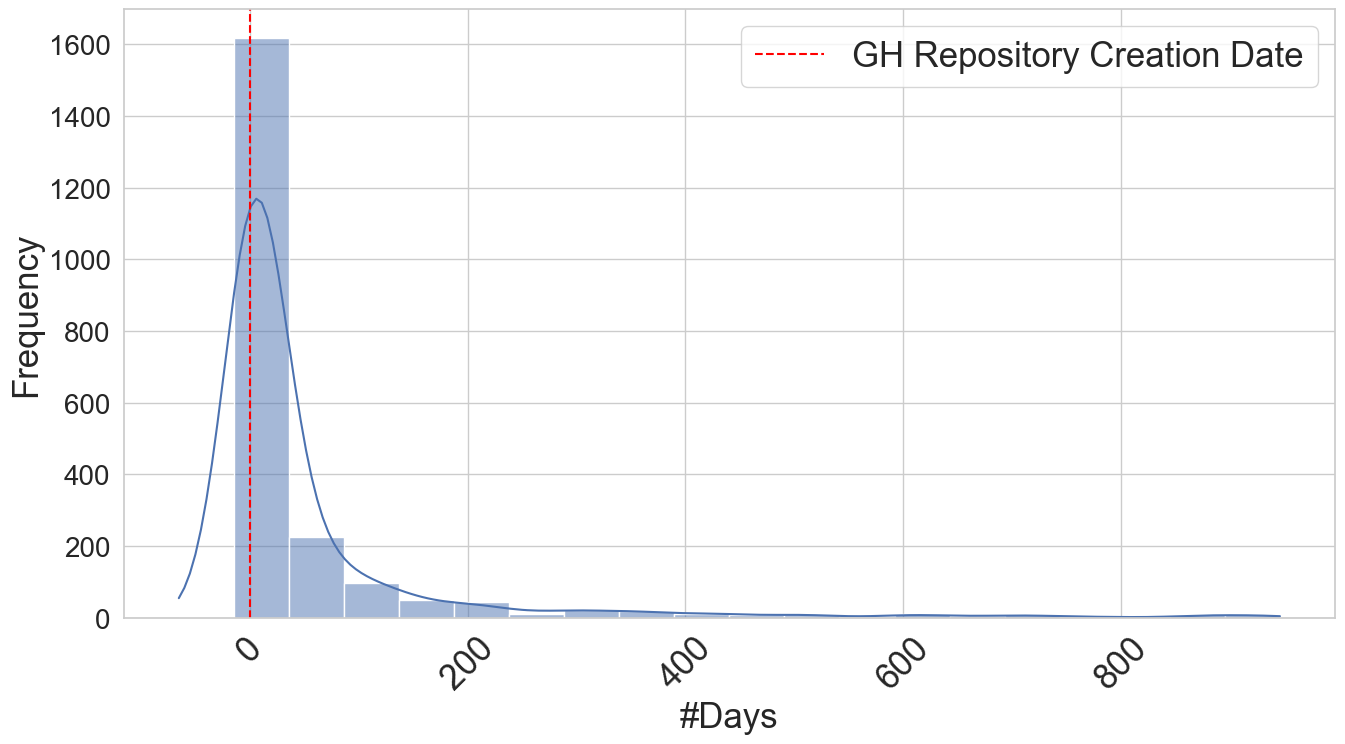

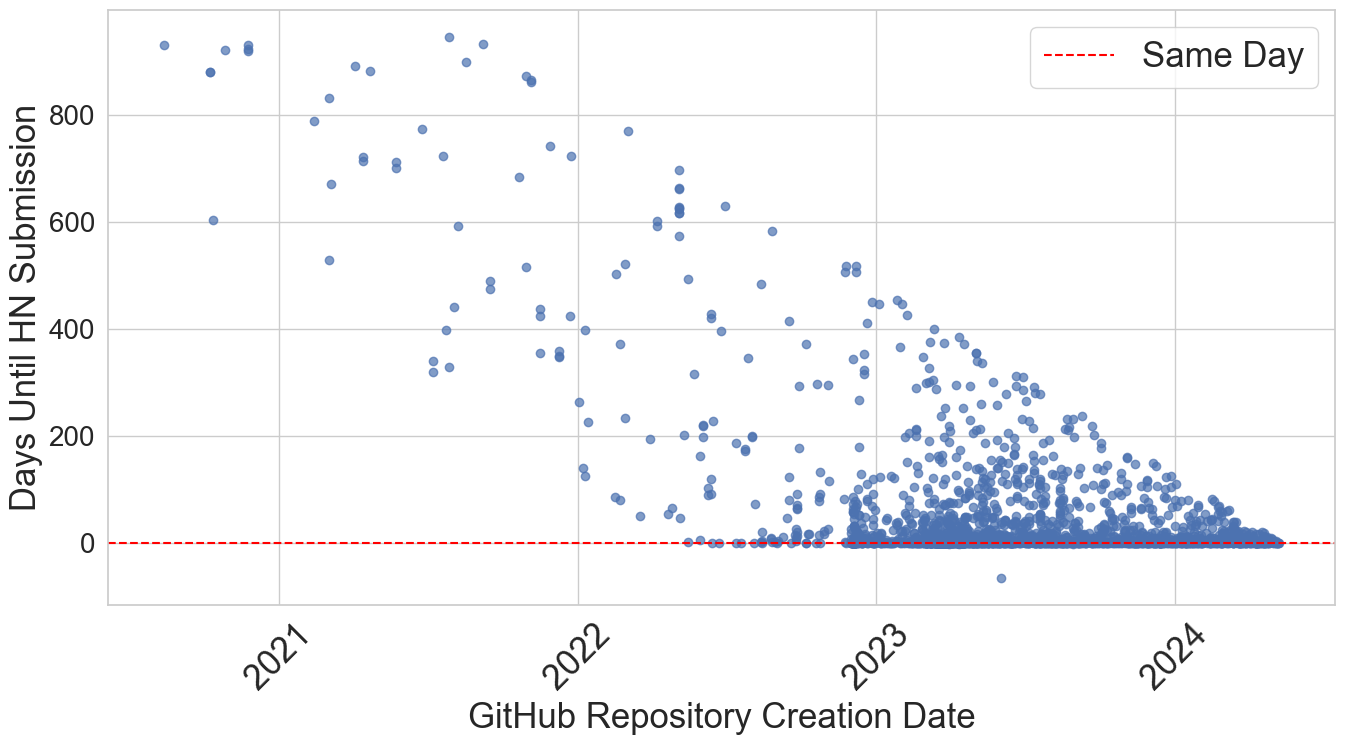

In [42]:
create_visualizations(merged_data)

## save the merged data

This contains both HN data as well as GH repository metadata including the creation date crucially. In case for further analysis.

In [ ]:
# Save the final dataset
HN_GH_METADATA_STORY_MERGED_CSV = '/content/drive/MyDrive/datasets/muict-naist-senior/rq3/rq3_creation_submission/rq3_github_hn_merged.csv'
merged_data.to_csv(HN_GH_METADATA_STORY_MERGED_CSV, index=False)
print(f'\nAnalysis complete! Results saved to {HN_GH_METADATA_STORY_MERGED_CSV}')